# K-Means Clustering: PySpark Implementation and Performance Analysis

Clustering is a widely used unsupervised machine learning technique to group similar data points. k- Means is a common clustering algorithm that assigns data points to clusters based on the nearest mean.

In this project we are going to cluster a MNIST dataset using K-means with both **Pyspark** and **scikit-learn**

## Objectif
 * Compare the performance (execution time and accuracy) of the PySpark implementation with a non-distributed framework (Scikit-learn)
 * Visualize the results for increasing dimensions and dataset sizes.
 * Analyze the scalability and efficiency of both implementations.

***
## 1. Implement K-Means with a non-distributed framework (Scikit-learn)

### 1.1. Dataset Preparation

For this project we are going to use MNIST dataset from kaggle [MNIST in CSV](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)


In [39]:
import pandas as pd

# Load training and test data
mnist_train = pd.read_csv('mnist_train.csv')
mnist_test = pd.read_csv('mnist_test.csv')

# Separate labels and features for training data
train_labels = mnist_train.iloc[:, 0]  # First column as labels
train_features = mnist_train.iloc[:, 1:]  # Remaining columns as features

# Similarly for test data
test_labels = mnist_test.iloc[:, 0]
test_features = mnist_test.iloc[:, 1:]

#Normalize the pixel intensity values (0–255) to a range of 0–1 for better clustering performance:
train_features = train_features / 255.0
test_features = test_features / 255.0

### 1.2. Applied the K-Means algorithm from sklearn

In [40]:
import time
from sklearn.cluster import KMeans

# Start the timer
start_time = time.time()

# Define the number of clusters (10 for digits 0–9)
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit the model on training data
kmeans.fit(train_features)

# Stop the timer and calculate the elapsed time
end_time = time.time()

# Get cluster assignments
train_clusters = kmeans.labels_

In [41]:
train_clusters

array([7, 5, 0, ..., 7, 8, 6], dtype=int32)

### 1.3. Mesure execution time of Scikit-learn

In [42]:
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

Execution Time: 23.4389 seconds


### 1.4.  Evaluate accuracy of Scikit-learn

In [43]:
from sklearn.metrics import adjusted_rand_score

# Compare clusters to actual labels using ARI
ari_score = adjusted_rand_score(train_labels, train_clusters)
print(f"Adjusted Rand Index: {ari_score}")

Adjusted Rand Index: 0.35988270313670967


***
## 2. Implement K-Means clustering algorithm using PySpark

Python API for Apache Spark is useful for distributed data processing, which is especially beneficial when working with large datasets like MNIST.

PySpark includes a built-in K-Means algorithm in the `pyspark.ml.clustering` module

In [44]:
pip install pyspark

### 2.1. Set up a Spark session

In [45]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [46]:
from pyspark.sql import SparkSession

# Create or get the existing SparkSession (with default configuration)
spark = SparkSession.builder.appName("MNIST").getOrCreate()

### 2.2. Loaded the MNIST dataset into a Spark DataFrame

In [47]:
# Load the MNIST training dataset as a Spark DataFrame
mnist_train_df = spark.read.csv('mnist_train.csv', header=True, inferSchema=True)

# Load the MNIST test dataset as a Spark DataFrame
mnist_test_df = spark.read.csv('mnist_test.csv', header=True, inferSchema=True)

# Show the first few rows of the training data
mnist_train_df.show(5)

+-----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+

### 2.3. Preprocessed the data by assembling pixel values into a single feature vector

In [48]:
# Separate features and labels for training data
features_cols = [c for c in mnist_train_df.columns if c != 'label']

assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
mnist_train_df = assembler.transform(mnist_train_df)

### 2.4. Applied the K-Means algorithm from Pyspark

In [49]:
# Train the K-Means model on the training data
import time

# Record start time
start_time = time.time()

# Set the number of clusters to 10 (for digits 0-9)
kmeans = KMeans().setK(10).setSeed(1)

# Fit the K-Means model on the data
model = kmeans.fit(mnist_train_df)


# Record end time
end_time = time.time()

# Get the resulting clusters
train_result = model.transform(mnist_train_df)

# Show the result with cluster labels
train_result.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    5|         2|
|    0|         6|
|    4|         1|
|    1|         4|
|    9|         9|
+-----+----------+
only showing top 5 rows



### 2.5. Mesure execution time of pyspark

In [50]:
# Calculate execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 67.5442 seconds


### 2.6.  Evaluate accuracy of Pyspark

In [51]:
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import adjusted_rand_score


# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(train_result)
print("Silhouette with squared euclidean distance = " + str(silhouette))

#Alternatively you can use Adjusted Rand Index
ari_score = adjusted_rand_score(train_result.select("label").rdd.flatMap(lambda x: x).collect(),
                                 train_result.select("prediction").rdd.flatMap(lambda x: x).collect())


print(f"Adjusted Rand Index: {ari_score}")

Silhouette with squared euclidean distance = 0.08736751643627494
Adjusted Rand Index: 0.332265415119265


***
## 3. Increasing dimensions and dataset sizes

### 3.1 Scikit-learn

In [54]:
import pandas as pd

# Load training and test data
mnist_train = pd.read_csv('mnist_train.csv')
mnist_test = pd.read_csv('mnist_test.csv')

# Separate labels and features for training data
train_labels = mnist_train.iloc[:, 0]  # First column as labels
train_features = mnist_train.iloc[:, 1:]  # Remaining columns as features

# Similarly for test data
test_labels = mnist_test.iloc[:, 0]
test_features = mnist_test.iloc[:, 1:]

#Normalize the pixel intensity values (0–255) to a range of 0–1 for better clustering performance:
train_features = train_features / 255.0
test_features = test_features / 255.0

Replicate dataset to simulate larger datasets

In [55]:
# Replicate dataset to simulate a larger dataset
large_train_features = pd.concat([train_features] * 5, ignore_index=True)
large_train_labels = pd.concat([train_labels] * 5, ignore_index=True)

In [56]:
import time
from sklearn.cluster import KMeans

# Start the timer
start_time = time.time()

# Define the number of clusters (10 for digits 0–9)
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit the model on training data
kmeans.fit(large_train_features)

# Stop the timer and calculate the elapsed time
end_time = time.time()

# Get cluster assignments
large_train_clusters = kmeans.labels_

In [57]:
execution_time = end_time - start_time
print(f"Execution Time for larger dataset: {execution_time:.4f} seconds")

Execution Time for larger dataset: 72.0428 seconds


In [58]:
from sklearn.metrics import adjusted_rand_score

# Compare clusters to actual labels using ARI
ari_score = adjusted_rand_score(large_train_labels, large_train_clusters)
print(f"Adjusted Rand Index: {ari_score}")

Adjusted Rand Index: 0.3599327185981175


### 3.2. Pyspark

In [59]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession

# Create or get the existing SparkSession (with default configuration)
spark = SparkSession.builder.appName("MNIST").getOrCreate()

In [60]:
# Load the MNIST training dataset as a Spark DataFrame
mnist_train_df = spark.read.csv('mnist_train.csv', header=True, inferSchema=True)

5 times dataset

In [61]:
# Original dataset
large_mnist_df = mnist_train_df

# Perform union 4 more times to make the dataset 5x larger
for _ in range(4):  # Repeat 4 times (5x total)
    large_mnist_df = large_mnist_df.union(mnist_train_df)

# Show the first few rows of the training data
large_mnist_df.show(5)

+-----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+

In [62]:
# Separate features and labels for training data
features_cols = [c for c in large_mnist_df.columns if c != 'label']

assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
large_mnist_df = assembler.transform(large_mnist_df)

In [63]:
# Train the K-Means model on the training data
import time

# Record start time
start_time = time.time()

# Set the number of clusters to 10 (for digits 0-9)
kmeans = KMeans().setK(10).setSeed(1)

# Fit the K-Means model on the data
model = kmeans.fit(large_mnist_df)


# Record end time
end_time = time.time()

# Get the resulting clusters
large_train_result = model.transform(large_mnist_df)

# Show the result with cluster labels
large_train_result.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    5|         5|
|    0|         8|
|    4|         9|
|    1|         0|
|    9|         7|
+-----+----------+
only showing top 5 rows



In [64]:
# Calculate execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 292.9488 seconds


In [65]:
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.metrics import adjusted_rand_score


# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(large_train_result)
print("Silhouette with squared euclidean distance = " + str(silhouette))

#Alternatively you can use Adjusted Rand Index
ari_score = adjusted_rand_score(large_train_result.select("label").rdd.flatMap(lambda x: x).collect(),
                                 large_train_result.select("prediction").rdd.flatMap(lambda x: x).collect())


print(f"Adjusted Rand Index: {ari_score}")

Silhouette with squared euclidean distance = 0.09409087801803616
Adjusted Rand Index: 0.35909448889087503


***
## 4. Analyze how the the performance of k-Means clustering ,with Pyspark and Scikit-learn, is affected by dataset size and dimensionality

1. 2 * original size
* sklearn: large_train_features = pd.concat([train_features] * 2, ignore_index=True)
* pyspark: large_mnist_df = mnist_train_df.union(mnist_train_df)
2. 5 * original size

### 4.1. Scalability

When i increase dataset 10 times the sklearn stopped running
* scikit-learn is limited by the memory of a single machine, making it unsuitable for very large datasets.
* PySpark is designed for big data and can scale across clusters.

### 4.2. Efficiency

* For smaller datasets, scikit-learn will likely be faster due to lower overhead.
* For larger datasets, PySpark should outperform scikit-learn as it can distribute computations across multiple nodes.

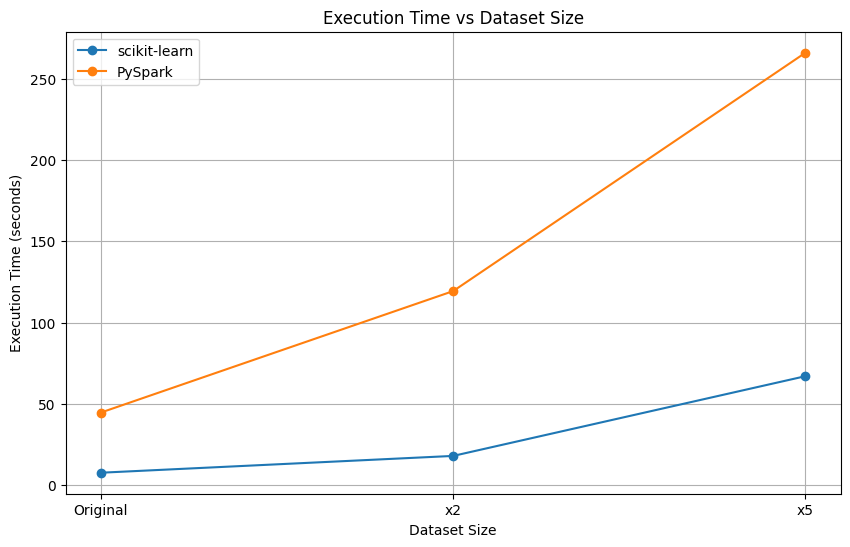

In [66]:
import matplotlib.pyplot as plt

# Data for execution time
dataset_sizes = ['Original', 'x2','x5']  # Labels for dataset sizes
sklearn_times = [7.6540, 17.9919, 67.0360]       # scikit-learn times
pyspark_times = [44.6606, 119.3814, 266.0181]     # PySpark times

# Plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, sklearn_times, label='scikit-learn', marker='o')
plt.plot(dataset_sizes, pyspark_times, label='PySpark', marker='o')

# Add labels and title
plt.title("Execution Time vs Dataset Size")
plt.xlabel("Dataset Size")
plt.ylabel("Execution Time (seconds)")
plt.legend()
plt.grid()
plt.show()

### 4.3. Accuracy

* Both frameworks should produce comparable results since they use similar underlying K-Means algorithms.
* Small differences might arise due to implementation details and numerical stability.